## What is GAN?

A Generative Adversarial Network (GAN) is a type of deep learning model used to generate new data samples similar to a given dataset. GANs consist of two neural networks:

- Generator - Generates fake data that resembles real data.
- Discriminator - Distinguishes between real and fake data.

Both networks train together in a competitive setting, improving each other over time.

## GAN Implementation on the MNIST Dataset

Below is a step-by-step implementation of GANs to generate handwritten digits using the MNIST dataset.

### Step 1: Import Required Libraries

- TensorFlow/Keras: Used to build and train the GAN.
- Numpy: Handles arrays and data manipulation.
- Matplotlib: Displays generated images.

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Sequential
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam
import numpy as np
import matplotlib.pyplot as plt


### Step 2: Load and Preprocess the MNIST Dataset

- MNIST Dataset consists of 28x28 grayscale images of handwritten digits (0-9).
- Normalization is done so that pixel values lie between -1 and 1 (improves GAN training).
- Batching & Shuffling ensures stable training.


In [2]:
# Load dataset
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize the data to [-1, 1] range (Tanh activation works best)
X_train = (X_train.astype(np.float32) - 127.5) / 127.5  
X_train = np.expand_dims(X_train, axis=-1)  # Reshape to (28, 28, 1)

# Define batch size
BUFFER_SIZE = 60000
BATCH_SIZE = 128

# Create dataset
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


### Step 3: Build the Generator Model

- Input: A 100-dimensional random noise vector.
- Dense Layers: Expands input gradually with increasing neuron counts.
- LeakyReLU: Allows small negative values for better gradient flow.
- Batch Normalization: Helps stabilize training.
- Reshape: Converts the output to a 28x28 grayscale image.

In [3]:
def build_generator():
    model = Sequential([
        Dense(256, input_shape=(100,), activation=LeakyReLU(0.2)),  
        BatchNormalization(),
        Dense(512, activation=LeakyReLU(0.2)),
        BatchNormalization(),
        Dense(1024, activation=LeakyReLU(0.2)),
        BatchNormalization(),
        Dense(28*28*1, activation='tanh'),  # Output shape (784,)
        Reshape((28, 28, 1))
    ])
    return model

generator = build_generator()
generator.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 batch_normalization_2 (Bat  (None, 1024)              

### Step 4: Build the Discriminator Model

- Flatten: Converts 2D image to 1D.
- Dense Layers: Reduces image to a single output value (real or fake).
- Sigmoid Activation: Outputs probability between 0 and 1.


In [4]:
def build_discriminator():
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),
        Dense(1024, activation=LeakyReLU(0.2)),
        Dense(512, activation=LeakyReLU(0.2)),
        Dense(256, activation=LeakyReLU(0.2)),
        Dense(1, activation='sigmoid')  # Outputs probability of real vs fake
    ])
    return model

discriminator = build_discriminator()
discriminator.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 1024)              803840    
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1460225 (5.57 MB)
Trainable params: 1460225 (5.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Step 5: Compile and Define Loss Functions

- Binary Crossentropy Loss: Used as we classify images as real or fake.
- Adam Optimizer: Helps stabilize training.
- GAN Model: Combines generator and discriminator.

In [5]:
# Optimizer
optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

# Compile Discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Make Discriminator Non-Trainable when Training GAN
discriminator.trainable = False

# Create GAN Model
gan_input = tf.keras.Input(shape=(100,))
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)
gan = tf.keras.Model(gan_input, gan_output)

# Compile GAN
gan.compile(loss='binary_crossentropy', optimizer=optimizer)


### Step 6: Training Loop

- Discriminator Training: Separates real and fake images.
- Generator Training: Improves fake images to fool the discriminator.
- Epochs & Image Saving: Monitors training progress.


4/4 [==============================] - 0s 5ms/step
Epoch 0: D Loss: 0.02446154528297484, G Loss: 4.863004684448242
1/1 [==============================] - 0s 22ms/step


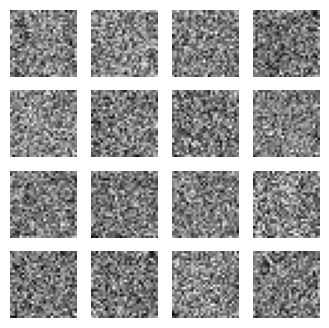

4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 5ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 3ms/step
Epoch 500: D Loss: 0.34089395403862, G Loss: 2.3579506874084473
1/1 [==============================] - 0s 31ms/step


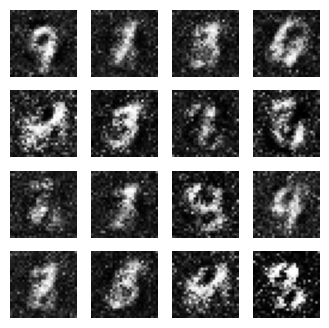

4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step
Epoch 1000: D Loss: 0.3723765015602112, G Loss: 2.645021915435791
1/1 [==============================] - 0s 23ms/step


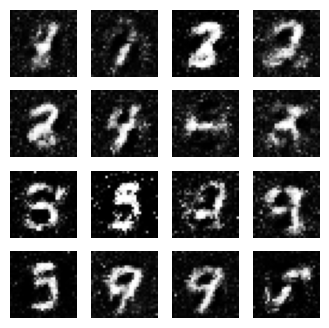

4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step
Epoch 1500: D Loss: 0.43935899436473846, G Loss: 2.1958510875701904
1/1 [==============================] - 0s 23ms/step


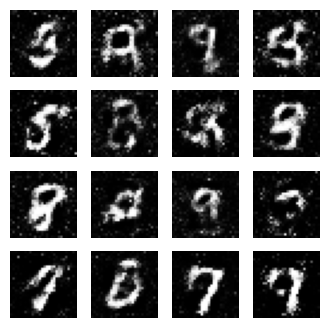

4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 3ms/step
Epoch 2000: D Loss: 0.4254753440618515, G Loss: 2.003502368927002
1/1 [==============================] - 0s 23ms/step


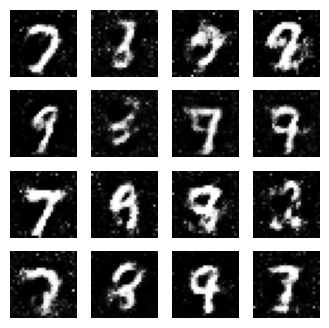

4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 4ms/step
Epoch 2500: D Loss: 0.3914404660463333, G Loss: 1.8846771717071533
1/1 [==============================] - 0s 22ms/step


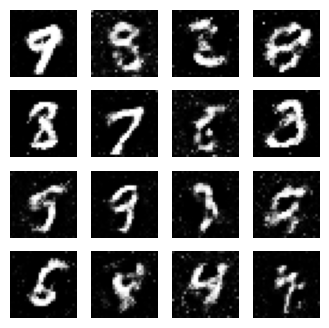

4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 4ms/step
Epoch 3000: D Loss: 0.5582484602928162, G Loss: 1.7356091737747192
1/1 [==============================] - 0s 23ms/step


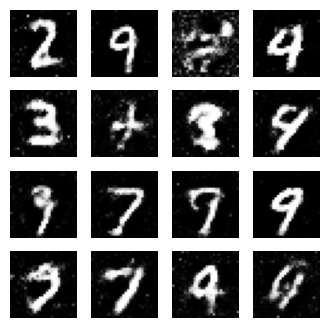

4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step
Epoch 3500: D Loss: 0.5311841666698456, G Loss: 1.6855475902557373
1/1 [==============================] - 0s 23ms/step


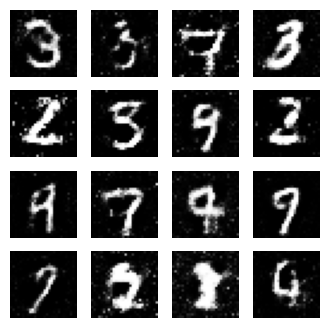

4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step
Epoch 4000: D Loss: 0.5241849422454834, G Loss: 1.7081247568130493
1/1 [==============================] - 0s 23ms/step


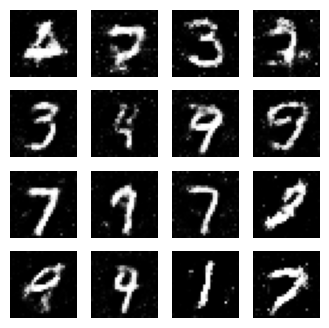

4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 3ms/step
Epoch 4500: D Loss: 0.5044761002063751, G Loss: 1.5927997827529907
1/1 [==============================] - 0s 30ms/step


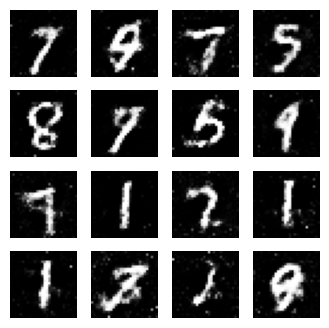

4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 3ms/step


In [7]:
EPOCHS = 5000  # Number of iterations
SAVE_INTERVAL = 500  # Save images every 500 epochs

def train_gan():
    for epoch in range(EPOCHS):
        # Train Discriminator
        real_images = next(iter(dataset))  # Get real images
        noise = np.random.normal(0, 1, (BATCH_SIZE, 100))  # Generate noise
        fake_images = generator.predict(noise)  # Create fake images
        
        # Labels
        real_labels = np.ones((BATCH_SIZE, 1))  
        fake_labels = np.zeros((BATCH_SIZE, 1))  

        # Train on real and fake data
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        noise = np.random.normal(0, 1, (BATCH_SIZE, 100))
        misleading_labels = np.ones((BATCH_SIZE, 1))  # Trick discriminator
        g_loss = gan.train_on_batch(noise, misleading_labels)

        # Print progress
        if epoch % SAVE_INTERVAL == 0:
            print(f"Epoch {epoch}: D Loss: {d_loss[0]}, G Loss: {g_loss}")
            save_generated_images(epoch)

# Function to save images
def save_generated_images(epoch):
    noise = np.random.normal(0, 1, (16, 100))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5  # Rescale from [-1,1] to [0,1]

    fig, axes = plt.subplots(4, 4, figsize=(4, 4))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i].reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.show()

# Train GAN
train_gan()
